## Linear interpolation for missing values

In [23]:
import pandas as pd
import datetime

In [24]:
data1 = pd.read_csv("feedwheat_basic.csv")

In [25]:
data1

,Date,WTFESY,Unnamed: 2
0,6/01/1999,NaN,NaN
1,13/01/1999,160.0,NaN
2,20/01/1999,157.0,NaN
3,27/01/1999,153.0,NaN
4,3/02/1999,NaN,NaN
...,...,...,...
1095,3/01/2020,NaN,NaN
1096,10/01/2020,430.0,NaN
1097,17/01/2020,430.0,NaN
1098,24/01/2020,430.0,NaN


In [26]:
data1.interpolate(limit_area = 'inside')

,Date,WTFESY,Unnamed: 2
0,6/01/1999,NaN,NaN
1,13/01/1999,160.000000,NaN
2,20/01/1999,157.000000,NaN
3,27/01/1999,153.000000,NaN
4,3/02/1999,151.500000,NaN
...,...,...,...
1095,3/01/2020,426.666667,NaN
1096,10/01/2020,430.000000,NaN
1097,17/01/2020,430.000000,NaN
1098,24/01/2020,430.000000,NaN


<AxesSubplot:>

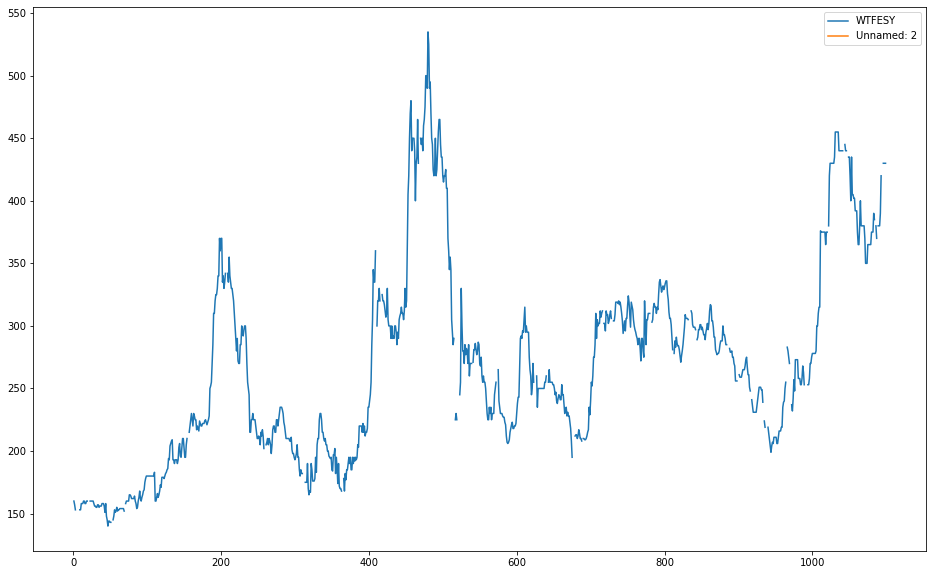

In [27]:
data1.plot(figsize = (16,10))

<AxesSubplot:>

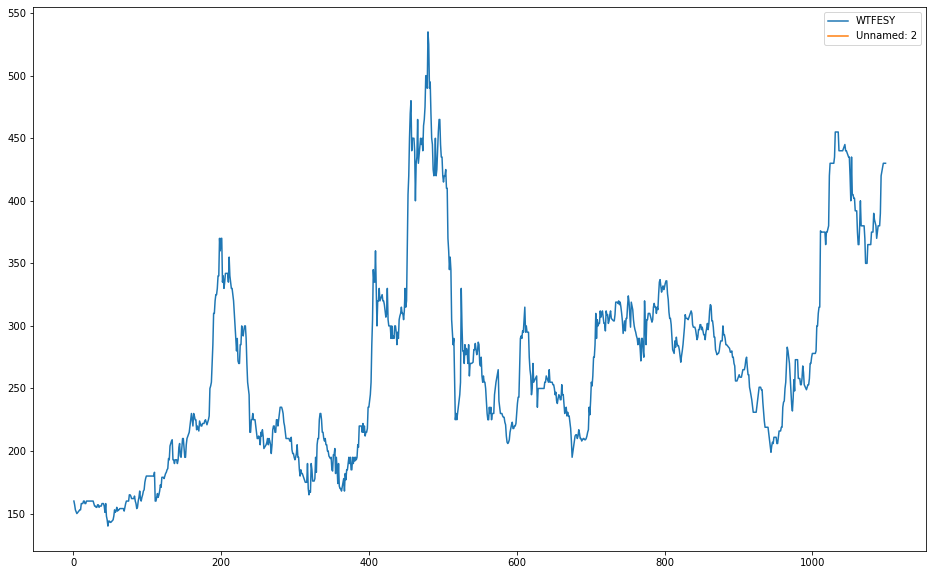

In [28]:
data1.interpolate(limit_area = 'inside').plot(figsize = (16,10))

In [30]:
data1.interpolate(limit_area = 'inside').to_csv("interpolated_feedwheat.csv")

##  CPI deflation

In [44]:
cpi = pd.read_csv("CPI.csv")

In [45]:
cpi

,Quarter,CPIDec20
0,1/09/1948,0.032
1,1/12/1948,0.032
2,1/03/1949,0.033
3,1/06/1949,0.034
4,1/09/1949,0.035
...,...,...
286,1/03/2020,0.995
287,1/06/2020,0.976
288,1/09/2020,0.991
289,1/12/2020,1.000


In [49]:
datetime.datetime.strptime("17/04/2000", "%d/%m/%Y")

datetime.datetime(2000, 4, 17, 0, 0)

In [64]:
datetime.datetime.strptime("17/04/2000", "%d/%m/%Y") + datetime.timedelta(days=7)

datetime.datetime(2000, 4, 24, 0, 0)

In [50]:
datetime.datetime.strptime("17/04/2000", "%d/%m/%Y") < datetime.datetime.strptime("16/04/2000", "%d/%m/%Y")

False

In [75]:
datetime.datetime.strftime(next_month(datetime.datetime.strptime("1/12/2000", "%d/%m/%Y")), "%d/%m/%Y")

'01/01/2001'

### Problem: new start in every month. Too many weeks, won't match up

New solution: generate a list of all the weeks by starting at the beginning of a TS and incrementing by 7 days until the end is reached (while datetime < enddate)

**In hindsight this is obviously unnecessary. Just use the weeks from the data. I'm very tired.**

Then: go through these weeks. Check: 

1. if month and year match any CPI quarterly entry
2. if month - 1 and year match any CPI quarterly entry
3. if month - 2 and year match any CPI quarterly entry.

In any of these cases, associate that week with the CPI entry found. 

Any exceptions? 

- no matches found

Or: have dict of weeks (or month) datetimes as keys and CPI as values. 

Or: find place of a certain date in an ordered list of CPI data to determine which CPI to use (the next one).

Or: have a dict of quarter dates: CPI vals. For each date with unknown CPI, round its day to 1 and month up to the next quarter so that:

1,2,3    -> 3

4,5,6    -> 6

7,8,9    -> 9

10,11,12 -> 12

In [105]:
def generatedict(df):
    return pd.Series(df.CPIDec20.values,index=df.Quarter).to_dict()


In [120]:
cpi_dict1 = generatedict(cpi)

In [103]:
'1/09/1948'[-7:-5]

'09'

In [110]:
'1/09/1948'[-4:]

'1948'

In [122]:
def get_CPI(date, cpi_dict = cpi_dict1):
    ## assume string e.g. "04/10/1948"
    month = date[-7:-5]
    
    if 1 <= int(month) <= 3: ## convert to correct quarter end date
        month = "03"
    elif 4 <= int(month) <= 6:
        month = "06"
    elif 7 <= int(month) <= 9:
        month = "09"
    elif 10 <= int(month) <= 12:
        month = "12"
    
    date = "1/" + month + "/" + date[-4:] 
    
    return cpi_dict[date]
    
    

In [125]:
get_CPI("04/11/2009")

0.805

In [137]:
data2 = pd.read_csv("interpolated_OTH - working.csv")

In [138]:
data2

,Date,16-18kg,18-20kg,20-22kg,22-24kg
0,10/01/2000,200.0,205.0,205.000000,200.000000
1,17/01/2000,202.0,207.0,205.000000,200.000000
2,24/01/2000,198.0,202.0,200.000000,198.000000
3,31/01/2000,198.0,202.0,198.000000,195.000000
4,7/02/2000,194.0,198.0,192.000000,191.000000
...,...,...,...,...,...
1005,30/12/2019,NaN,683.0,726.333333,726.333333
1006,6/01/2020,NaN,658.0,723.000000,723.000000
1007,13/01/2020,NaN,658.0,730.000000,730.000000
1008,20/01/2020,NaN,733.0,733.000000,733.000000


In [139]:
newcol = []

for date in data2["Date"]:
    newcol.append(get_CPI(date))

In [140]:
newcol

[0.595,
 0.595,
 0.595,
 0.595,
 0.595,
 0.595,
 0.595,
 0.595,
 0.595,
 0.595,
 0.595,
 0.595,
 0.599,
 0.599,
 0.599,
 0.599,
 0.599,
 0.599,
 0.599,
 0.599,
 0.599,
 0.599,
 0.599,
 0.622,
 0.622,
 0.622,
 0.622,
 0.622,
 0.622,
 0.622,
 0.622,
 0.622,
 0.622,
 0.622,
 0.622,
 0.622,
 0.624,
 0.624,
 0.624,
 0.624,
 0.624,
 0.624,
 0.624,
 0.624,
 0.624,
 0.624,
 0.624,
 0.624,
 0.631,
 0.631,
 0.631,
 0.631,
 0.631,
 0.631,
 0.631,
 0.631,
 0.631,
 0.631,
 0.631,
 0.631,
 0.636,
 0.636,
 0.636,
 0.636,
 0.636,
 0.636,
 0.636,
 0.636,
 0.636,
 0.636,
 0.636,
 0.636,
 0.636,
 0.637,
 0.637,
 0.637,
 0.637,
 0.637,
 0.637,
 0.637,
 0.637,
 0.637,
 0.637,
 0.637,
 0.637,
 0.637,
 0.643,
 0.643,
 0.643,
 0.643,
 0.643,
 0.643,
 0.643,
 0.643,
 0.643,
 0.643,
 0.643,
 0.649,
 0.649,
 0.649,
 0.649,
 0.649,
 0.649,
 0.649,
 0.649,
 0.649,
 0.649,
 0.649,
 0.649,
 0.654,
 0.654,
 0.654,
 0.654,
 0.654,
 0.654,
 0.654,
 0.654,
 0.654,
 0.654,
 0.654,
 0.654,
 0.654,
 0.6579999999999999,
 0.

In [142]:
data2["CPI (Dec20$)"] = newcol

In [143]:
data2

,Date,16-18kg,18-20kg,20-22kg,22-24kg,CPI (Dec20$)
0,10/01/2000,200.0,205.0,205.000000,200.000000,0.595
1,17/01/2000,202.0,207.0,205.000000,200.000000,0.595
2,24/01/2000,198.0,202.0,200.000000,198.000000,0.595
3,31/01/2000,198.0,202.0,198.000000,195.000000,0.595
4,7/02/2000,194.0,198.0,192.000000,191.000000,0.595
...,...,...,...,...,...,...
1005,30/12/2019,NaN,683.0,726.333333,726.333333,0.991
1006,6/01/2020,NaN,658.0,723.000000,723.000000,0.995
1007,13/01/2020,NaN,658.0,730.000000,730.000000,0.995
1008,20/01/2020,NaN,733.0,733.000000,733.000000,0.995


In [145]:
data2.to_csv("OTH_with_CPI.csv")